In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.backends.backend_pdf import PdfPages
import time
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp

from mpl_toolkits import mplot3d

%matplotlib notebook

In [44]:
# Set up the parameters
M = 10000 # Mass of the central black hole 
m = 1 # Mass of the planet 
G = 1 # Gravitational Constant 
c = 1 # Speed of light
J = 0
J = -9.0e7 #Rotational angular momentum of central black hole

#R = 100000000 #Circular orbit
#L = 1000000 #Circular orbit

#R = 100000000 #Elliptical orbit
#L = 900000 #Elliptical orbit

#R = 100000000 #More Elliptical orbit
#L = 250000 #More Elliptical orbit

#R = 900000 #test Elliptical orbit
#L = 54000 #test Elliptical orbit

R = 700000 #Whirl-zoom
L = 39000 #Whirl-zoom

shwr_R = M + np.sqrt(M**2 - (J/M)**2)
print(J/(M**2))
print(shwr_R)
print(M + np.sqrt(M**2 - (J/M)**2 * np.cos(np.pi/2)**2))

-0.9
14358.898943540673
20000.0


In [45]:
def csc(x):
    if np.sin(x) == 0:
        raise ValueError("Cosecant is undefined for x = n * pi where n is an integer.")
    return 1 / np.sin(x)

def cot(x):
    return 1 / np.tan(x)

def pRdt(R,pR,time,pt,theta,ptheta,phi):
    term1_denominator = R**2 + (J**2 * np.cos(theta)**2) / M**2
    term1 = -2 * ptheta**2 * R / term1_denominator**2

    term2_denominator = (J**2/M**2 - 2*M*R + R**2) * term1_denominator**2
    term2 = 8 * J * pt * L * R**2 / term2_denominator

    term3 = -2 * pR**2 * R * (J**2/M**2 - 2*M*R + R**2) / term1_denominator**2

    term4 = pR**2 * (-2*M + 2*R) / term1_denominator

    term5_denominator = (J**2/M**2 - 2*M*R + R**2)**2 * term1_denominator
    term5 = 4 * J * pt * L * R * (-2*M + 2*R) / term5_denominator

    term6_denominator = (J**2/M**2 - 2*M*R + R**2) * term1_denominator
    term6 = -4 * J * pt * L / term6_denominator

    term7 = L**2 * (-2*M + 2*R) * 1/np.sin(theta)**2 / term6_denominator

    term8 = -2 * L**2 * R * (J**2/M**2 - 2*M*R + R**2 - (J**2 * np.sin(theta)**2)/M**2) * 1/np.sin(theta)**2 / term2_denominator

    term9_numerator = L**2 * (-2*M + 2*R) * (J**2/M**2 - 2*M*R + R**2 - (J**2 * np.sin(theta)**2)/M**2)
    term9_denominator = (J**2/M**2 - 2*M*R + R**2)**2 * term1_denominator
    term9 = -term9_numerator * 1/np.sin(theta)**2 / term9_denominator

    term10_numerator = pt**2 * (2*R - (4*J**2*R**2*np.sin(theta)**2)/(M*term1_denominator**2) + (2*J**2*np.sin(theta)**2)/(M*term1_denominator))
    term10_denominator = J**2/M**2 - 2*M*R + R**2
    term10 = -term10_numerator / term10_denominator

    term11_numerator = pt**2 * (-2*M + 2*R) * (J**2/M**2 + R**2 + (2*J**2*R*np.sin(theta)**2)/(M*term1_denominator))
    term11_denominator = term10_denominator**2
    term11 = term11_numerator / term11_denominator

    result = -(1/(2*m)) * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11)
    return result

def pthetadt(R,pR,time,pt,theta,ptheta,phi):
    term1_denominator = M**2 * (J**2 / M**2 - 2 * M * R + R**2) * (R**2 + (J**2 * np.cos(theta)**2) / M**2)
    term1 = - (2 * J**2 * L**2 * 1 / np.tan(theta)) / term1_denominator
    
    term2_denominator = M**2 * (R**2 + (J**2 * np.cos(theta)**2) / M**2)**2
    term2 = (2 * J**2 * ptheta**2 * np.cos(theta) * np.sin(theta)) / term2_denominator

    term3_denominator = M**2 * (J**2 / M**2 - 2 * M * R + R**2) * (R**2 + (J**2 * np.cos(theta)**2) / M**2)**2
    term3 = - (8 * J**3 * pt * L * R * np.cos(theta) * np.sin(theta)) / term3_denominator

    term4 = (2 * J**2 * pR**2 * (J**2 / M**2 - 2 * M * R + R**2) * np.cos(theta) * np.sin(theta)) / term2_denominator

    term5_denominator = M**2 * (J**2 / M**2 - 2 * M * R + R**2) * (R**2 + (J**2 * np.cos(theta)**2) / M**2)**2
    term5 = (2 * J**2 * L**2 * 1 / np.tan(theta) * (J**2 / M**2 - 2 * M * R + R**2 - (J**2 * np.sin(theta)**2) / M**2)) / term5_denominator

    term6_denominator = (J**2 / M**2 - 2 * M * R + R**2) * (R**2 + (J**2 * np.cos(theta)**2) / M**2)
    term6 = - (2 * L**2 * 1 / np.tan(theta) * 1 / np.sin(theta)**2 * (J**2 / M**2 - 2 * M * R + R**2 - (J**2 * np.sin(theta)**2) / M**2)) / term6_denominator

    term7_numerator = (4 * J**2 * R * np.cos(theta) * np.sin(theta)) / (M * (R**2 + (J**2 * np.cos(theta)**2) / M**2)) + (4 * J**4 * R * np.cos(theta) * np.sin(theta)**3) / (M**3 * (R**2 + (J**2 * np.cos(theta)**2) / M**2)**2)
    term7_denominator = J**2 / M**2 - 2 * M * R + R**2
    term7 = - pt**2 * term7_numerator / term7_denominator

    result = -(1 / (2 * m)) * (term1 + term2 + term3 + term4 + term5 + term6 + term7)
    return result


def system_of_odes(t,y):
    R, pR, time, pt, theta, ptheta, phi = y
    
    mfac = (1/(2*m)) 
    
    denom = ((J**2 / M**2) - 2*M*R + R**2)*(R**2 + (J**2 * np.cos(theta)**2)/(M**2))
    
    
    dRdt = ((m * R**2)/L)*(((J**2 / M**2) - 2*M*R + R**2)/(R**2 + (J**2 * np.cos(theta)**2)/(M**2)))*((pR)/(m))
    
    dpRdt = ((m * R**2)/L)*pRdt(R,pR,time,pt,theta,ptheta,phi)

    dtimedt = -(mfac)*((m * R**2)/L)*((4*J*L*R)/(denom) + ( (J**2 / M**2) + R**2 + (2*J**2 * R*np.sin(theta)**2)/(M*(R**2 + (J**2 * np.cos(theta)**2)/(M**2))) )/((J**2 / M**2) - 2*M*R + R**2))
    
    dptdt = 0

    dthetadt = ((m * R**2)/L)*(ptheta/(m*(R**2 + (J**2 * np.cos(theta)**2)/(M**2))))
    
    dpthetadt = ((m * R**2)/L)*pthetadt(R,pR,time,pt,theta,ptheta,phi)
        
    dphidt = -(mfac)*((m * R**2)/L)*((4*J*pt*R)/denom - (2*L*csc(theta)**2 *((J**2 / M**2) - 2*M*R + R**2) - (J**2 * np.sin(theta)**2)/(M**2))/denom)

    return [dRdt,dpRdt,dtimedt,dptdt, dthetadt, dpthetadt, dphidt]


def Constraint(R,pR,time,pt,theta,ptheta,phi):
    term1_denom = R**2 + (J**2 * np.cos(theta)**2) / M**2
    term1 = ptheta**2 / term1_denom

    term2_denom = (J**2 / M**2 - 2 * M * R + R**2) * (R**2 + (J**2 * np.cos(theta)**2) / M**2)
    term2 = - (4 * J * pt * L * R) / term2_denom

    term3 = pR**2 * (J**2 / M**2 - 2 * M * R + R**2) / term1_denom

    term4_denom = (J**2 / M**2 - 2 * M * R + R**2) * (R**2 + (J**2 * np.cos(theta)**2) / M**2)
    term4 = L**2 * (1 / np.sin(theta)**2) * (J**2 / M**2 - 2 * M * R + R**2 - (J**2 * np.sin(theta)**2) / M**2) / term4_denom

    term5_denom = J**2 / M**2 - 2 * M * R + R**2
    term5 = - (pt**2 * (J**2 / M**2 + R**2 + (2 * J**2 * R * np.sin(theta)**2) / (M * (R**2 + (J**2 * np.cos(theta)**2) / M**2)))) / term5_denom

    H = (1 / (2 * m)) * (term1 + term2 + term3 + term4 + term5)

    return H

def secant(f,x0,x1):
    x = np.array([x0,x1])

    for i in range(50):
        if f(x1) - f(x0) == 0:
            #print("Division by zero")
            return x[-1]

        xn_1 = x1 - f(x1) * ((x1 - x0)/(f(x1) - f(x0)))
        x = np.append(x, xn_1)
        x0 = x1
        x1 = xn_1
    return x[-1]

<IPython.core.display.Javascript object>


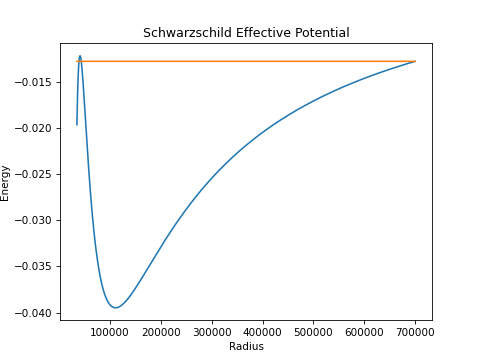

In [46]:
ra = np.linspace(3.5e4,7e5,100000)

U = np.zeros_like(ra)
for i in range(len(ra)):
  U[i] = (-G*M)/(ra[i]) + (L**2 / (2*ra[i]**2)) - (G * M * L**2)/(ra[i]**3)

U_p = np.zeros_like(ra)
U_p[0] = (-G*M)/(R) + (L**2 / (2*R**2)) - (G * M * L**2)/(R**3)
for i in range(len(ra)-1):
  U_p[i+1]=U_p[0]

fig5 = plt.figure()
plt.plot(ra,U)
plt.plot(ra,U_p)
plt.xlabel('Radius')
plt.ylabel('Energy')
plt.title('Schwarzschild Effective Potential')

#plt.savefig('Schw_potential_ellip.png', format='png')
plt.show()

In [49]:
theta_initial = (np.pi)/2
ptheta_initial = 0.0

pt_initial = secant(lambda pt: Constraint(R,0,0,pt,theta_initial,ptheta_initial,0) + (m/2),0,1)
r0 = np.array([R,0,0,pt_initial,theta_initial,ptheta_initial,0]) #R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)

initial_conditions = r0

#print(pt_initial)

ti_initial = 0
tf = 40
t_span = (ti_initial,tf)

start = time.time()
t_eval = np.linspace(ti_initial,tf,10000)

sol = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, rtol = 1e-8, atol = 1e-10)

const_change = np.array([-m/2])

for i in range(len(sol.t)-1):
    const_change = np.append(const_change,Constraint(sol.y[0,i],sol.y[1,i],sol.y[2,i],sol.y[3,i],sol.y[4,i],sol.y[5,i],sol.y[6,i]))
    
end = time.time()
print(end - start) 

2.2557313442230225


<IPython.core.display.Javascript object>


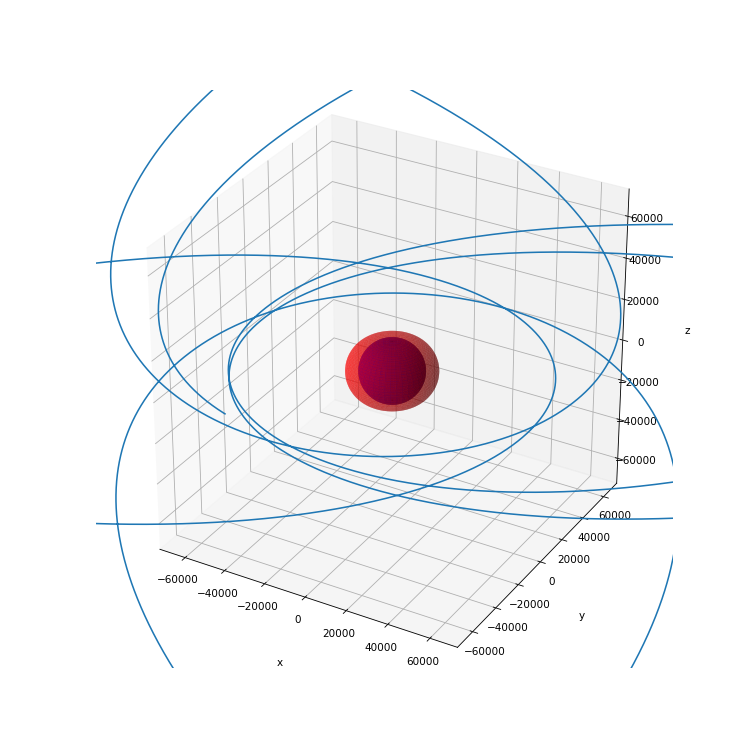

In [48]:
Theta = sol.y[4,:]
Phi = sol.y[6,:]
X = sol.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()


ax1.plot3D(X,Y,Z)

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_shwr = shwr_R * np.outer(np.cos(u), np.sin(v))
y_shwr = shwr_R * np.outer(np.sin(u), np.sin(v))
z_shwr = shwr_R * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

ax1.plot_surface(x_shwr,y_shwr,z_shwr, color = 'b')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.5)

zoom = 10.0

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()

<IPython.core.display.Javascript object>


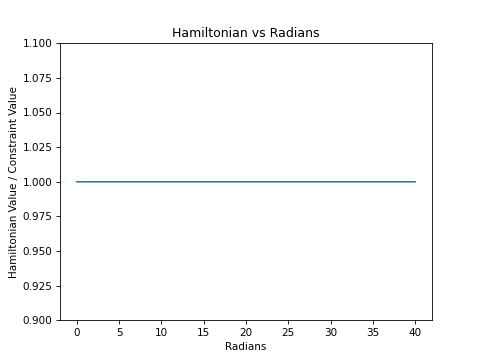

In [40]:
fig6 = plt.figure()
plt.plot(sol.t, const_change/(-m/2))
plt.ylim([0.9, 1.1])
plt.xlabel('Radians')
plt.ylabel('Hamiltonian Value / Constraint Value')
plt.title('Hamiltonian vs Radians')
#plt.savefig('Hamil_Restrict_eccenlow.png', format='png')
plt.show()

<IPython.core.display.Javascript object>


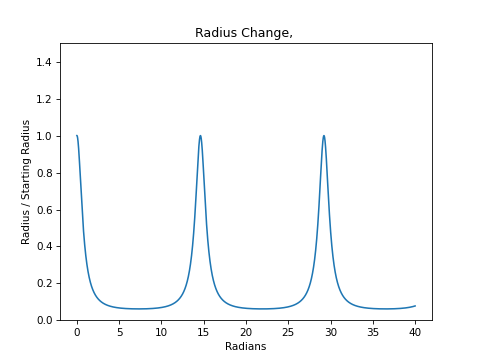

In [41]:
#Plot change in radius
peak_R, _ = find_peaks(sol.y[0,:], height=0)

#orbital_period = 

#plt.scatter(peak_R, (r[peak_R,0])/R)
fig7 = plt.figure()
plt.plot(sol.t,(sol.y[0,:])/R)
plt.ylim([0.0, 1.5])
plt.xlabel('Radians')
plt.ylabel('Radius / Starting Radius')
plt.title('Radius Change, ')

#plt.savefig('Radius_whirl.png', format='png')
plt.show()

<IPython.core.display.Javascript object>


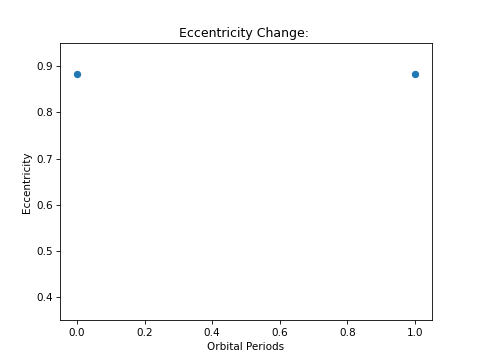

In [42]:
#Calculate change in eccentricity
r_max_peaks, _ = find_peaks(sol.y[0,:], height=0)
r_min_peaks, _ = find_peaks(-sol.y[0,:], height= -R)

eccen = np.array([])
orb_periods = np.array([])

for i in range(min(len(r_min_peaks),len(r_max_peaks))):
    eccen_value = 1 - 2/((sol.y[0,r_max_peaks[i]]/sol.y[0,r_min_peaks[i]]) + 1)
    eccen = np.append(eccen,eccen_value)
    orb_periods = np.append(orb_periods,i)

fig8 = plt.figure()
#print(eccen)
plt.scatter(orb_periods,eccen)
plt.ylim([0.35, .95])
plt.xlabel('Orbital Periods')
plt.ylabel('Eccentricity')
plt.title('Eccentricity Change: ')

#plt.savefig('eccen_lowham.png', format='png')
plt.show()